In [24]:
import numpy as np
import os
import json
from pathlib import Path
import time

from smartem.smartem import SmartEM
from smartem.smartem_par import SmartEMPar
from smartem.online import microscope as microscope_client
from smartem.online import get_rescan_maps

import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

In [25]:
repo_dir = Path(os.getcwd()).parents[1]
save_dir = repo_dir / "experiments/parallelization/temp"

In [26]:
# initializing fake random microscope
params = {"W": 1024, "H": 1024, "dtype": np.uint16, "sleep": True}
microscope = microscope_client.FakeRandomMicroscope(params=params)

# initializing get_rescan_map
params = {"type": "half", "fraction": 0.5}
get_rescan_map = get_rescan_maps.GetRescanMapTest(params=params)
smart_em = SmartEM(microscope, get_rescan_map)

In [27]:
# initializing fake random microscope
params = {"W": 1024, "H": 1024, "dtype": np.uint16, "sleep": True}
microscope = microscope_client.FakeRandomMicroscope(params=params)

# initializing get_rescan_map
params = {"type": "half", "fraction": 0.5}
get_rescan_map = get_rescan_maps.GetRescanMapTest(params=params)
smart_em_par = SmartEMPar(microscope, get_rescan_map)

In [28]:
with open(
    repo_dir / "examples/default_smartem_params.json",
    "r",
) as f:
    params = json.load(f)
    if "resolution" in params:
        params["resolution"] = tuple(params["resolution"])
    params["plot"] = False

# Don't acquire as many tiles as there will be sleeping involved
with open(
    repo_dir / "examples/default_imaging_params_short.json",
    "r",
) as f:
    params_imaging = json.load(f)
    params.update(params_imaging)

params["verbose"] = 0

smart_em.initialize()
smart_em_par.initialize()

In [29]:
data_total_times = []
data_task_times = []
data_method = []

smart_em.get_rescan_map.params["sleep_time"] = 0.5 # 2048x1768 pixels w/ 0.14 s/Mpx
smart_em_par.get_rescan_map.params["sleep_time"] = 0.5

params["sleep"] = True

for fast_dwt in tqdm([25e-9, 50e-9, 100e-9, 500e-9]):
    for rep in tqdm(range(1), leave=False):
        params["fast_dwt"] = fast_dwt

        tic = time.time()
        smart_em.acquire_many_grids(
            coordinates=params["coordinates"], params=params, save_dir=save_dir
        )
        toc_serial = time.time()
        smart_em_par.acquire_many_grids(
            coordinates=params["coordinates"], params=params, save_dir=save_dir
        )
        toc_par = time.time()

        par_time = toc_par - toc_serial
        ser_time = toc_serial - tic
        print(f"{par_time} vs {ser_time}: {(ser_time-par_time)/ser_time*100}%")

        data_task_times.append(fast_dwt)
        data_total_times.append(par_time)
        data_method.append("Parallel")
        data_task_times.append(fast_dwt)
        data_total_times.append(ser_time)
        data_method.append("Serial")

data = {"Fast Imaging Time (s)": data_task_times, "Total Time (s)": data_total_times, "Method": data_method}
df = pd.DataFrame(data)


 25%|██▌       | 1/4 [00:30<01:32, 30.83s/it]

13.826842069625854 vs 16.996272802352905: 18.647798664941913%


 50%|█████     | 2/4 [01:06<01:07, 33.78s/it]

14.923041105270386 vs 20.92344093322754: 28.677882605954157%


 75%|███████▌  | 3/4 [01:58<00:42, 42.02s/it]

22.90189814567566 vs 28.918540954589844: 20.805485374805002%


100%|██████████| 4/4 [04:58<00:00, 74.59s/it]

86.93294835090637 vs 92.92238903045654: 6.445637851160986%


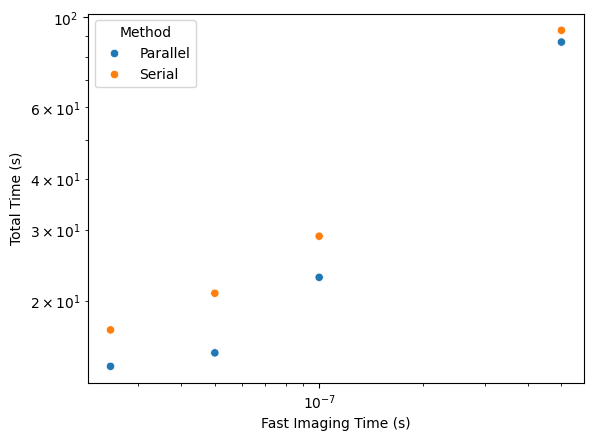

In [30]:
sns.scatterplot(df, x="Fast Imaging Time (s)", y="Total Time (s)", hue="Method")
plt.xscale('log')
plt.yscale('log')